In [217]:
# Normal imports for everybody
import keras
#from context import * # imports the MDN layer 
import mdn
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

(10000, 3000) (10000, 500)


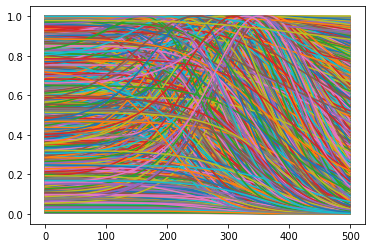

In [218]:
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')

X=np.reshape(X,(-1,1000,3))

for i in range(3):
    mean=np.mean(X[:,:,i])
    std=np.std(X[:,:,i])
    X[:,:,i]=(X[:,:,i]-mean)/std
'''
plt.plot(np.transpose(X[:,:,0]))
plt.show()
plt.plot(np.transpose(X[:,:,1]))
plt.show()
plt.plot(np.transpose(X[:,:,2]))
plt.show()
'''
X=np.reshape(X,(-1,1000*3)) #Flatten

Y=Y*1e20

#plt.plot(np.transpose(Y))

x_data=X
y_data=Y
print(np.shape(x_data),np.shape(y_data))

In [219]:
N_INPUT=3*1000
N_MIXES = 3
N_OUTPUT = 500

model = keras.Sequential()
model.add(keras.layers.Dense(1000, batch_input_shape=(None, N_INPUT), activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(500, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(mdn.MDN(N_OUTPUT, N_MIXES)) #output dimensions, no. of mixes.
model.compile(loss=mdn.get_mixture_loss_func(N_OUTPUT,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[mdn.get_mixture_mse_accuracy(1,N_MIXES)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1000)              3001000   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1000)              4000      
_________________________________________________________________
dense_8 (Dense)              (None, 500)               500500    
_________________________________________________________________
batch_normalization_8 (Batch (None, 500)               2000      
_________________________________________________________________
dense_9 (Dense)              (None, 1000)              501000    
_________________________________________________________________
batch_normalization_9 (Batch (None, 1000)              4000      
_________________________________________________________________
mdn_3 (MDN)                  (None, 3003)              3006003   
Total para

In [220]:
history = model.fit(x=x_data, y=y_data, batch_size=100, epochs=20, validation_split=0.15,callbacks=[keras.callbacks.TerminateOnNaN()])

Train on 8500 samples, validate on 1500 samples
Epoch 1/20
8500/8500 [==============================] - 15s 2ms/step - loss: 470.1507 - val_loss: 1629.3949
Epoch 2/20
8500/8500 [==============================] - 10s 1ms/step - loss: 84.6424 - val_loss: 341.2546
Epoch 3/20
8500/8500 [==============================] - 10s 1ms/step - loss: 123.0148 - val_loss: 327.0388
Epoch 4/20
8500/8500 [==============================] - 10s 1ms/step - loss: 38.0728 - val_loss: 1837.8178
Epoch 5/20
8500/8500 [==============================] - 10s 1ms/step - loss: 25.7362 - val_loss: 537.2843
Epoch 6/20
8500/8500 [==============================] - 10s 1ms/step - loss: 4.7506 - val_loss: 654.8961
Epoch 7/20
8500/8500 [==============================] - 9s 1ms/step - loss: 4.3189 - val_loss: 708.2956
Epoch 8/20
8500/8500 [==============================] - 9s 1ms/step - loss: 111.4208 - val_loss: 1934.1590
Epoch 9/20
8500/8500 [==============================] - 9s 1ms/step - loss: 102.3003 - val_loss: 560.1

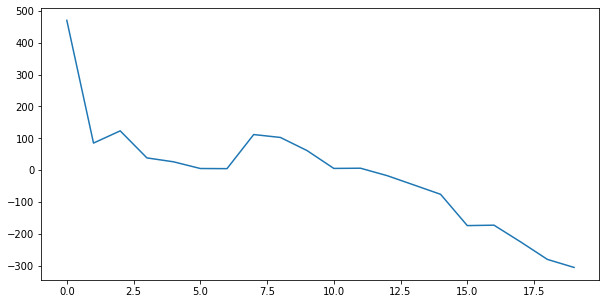

In [221]:
plt.figure(figsize=(10, 5))
#plt.ylim([0,9])
plt.plot(history.history['loss'])
#plt.loglog(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

The `mdn` module provides a function to sample from these parameters as follows. First the parameters are split up into `mu`s, `sigma`s and `pi`s, then the categorical distribution formed by the `pi`s is sampled to choose which mixture component should be sampled, then that component's `mu`s and `sigma`s is used to sample from a multivariate normal model, here's the code:

    def sample_from_output(params, output_dim, num_mixes, temp=1.0):
        """Sample from an MDN output with temperature adjustment."""
        mus = params[:num_mixes*output_dim]
        sigs = params[num_mixes*output_dim:2*num_mixes*output_dim]
        pis = softmax(params[-num_mixes:], t=temp)
        m = sample_from_categorical(pis)
        # Alternative way to sample from categorical:
        # m = np.random.choice(range(len(pis)), p=pis)
        mus_vector = mus[m*output_dim:(m+1)*output_dim]
        sig_vector = sigs[m*output_dim:(m+1)*output_dim] * temp  # adjust for temperature
        cov_matrix = np.identity(output_dim) * sig_vector
        sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
        return sample
        
If you only have one prediction to sample from, you can use the function as is; but if you need to sample from a lot of predictions at once (as in the following sections), you can use `np.apply_along_axis` to apply it to a whole numpy array of predicted parameters.

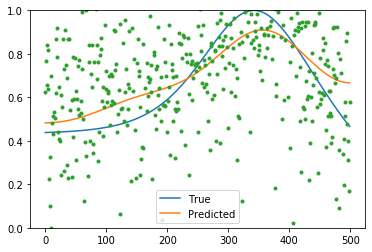

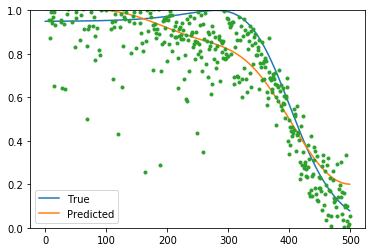

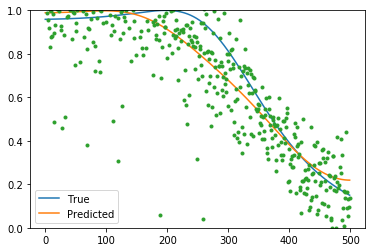

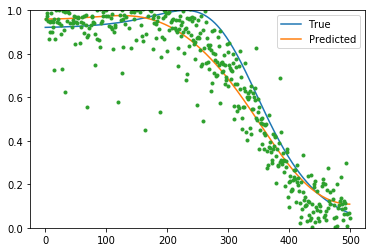

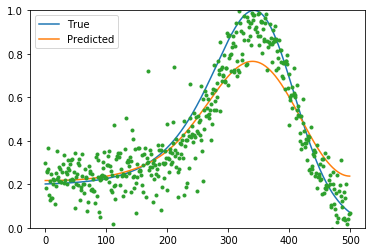

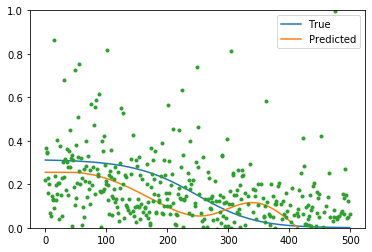

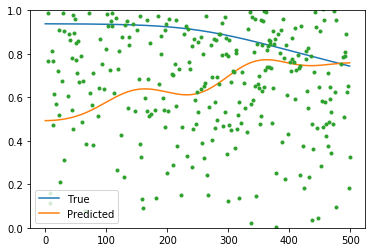

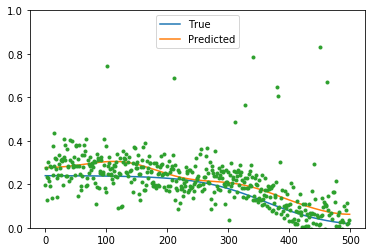

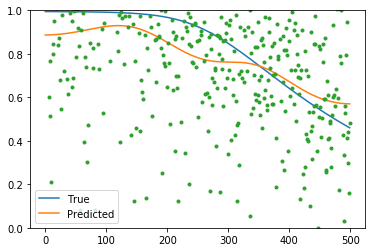

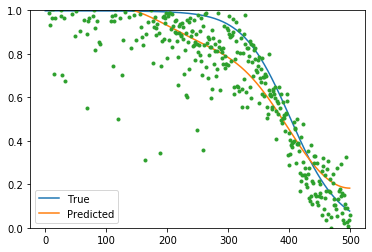

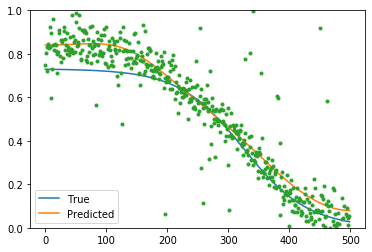

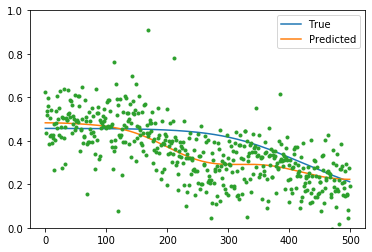

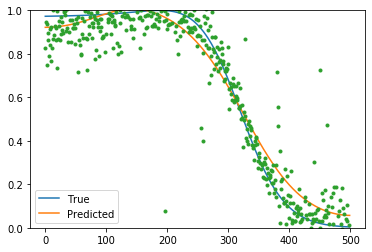

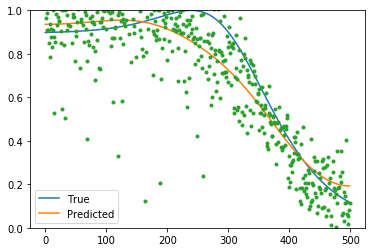

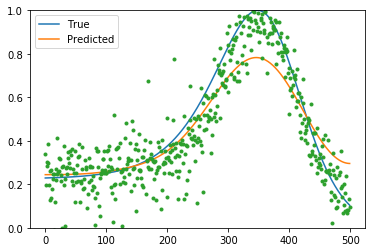

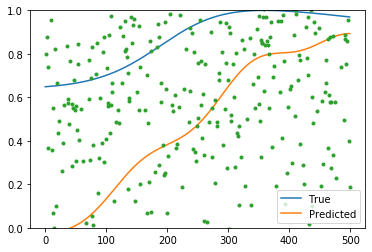

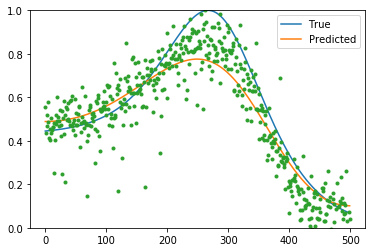

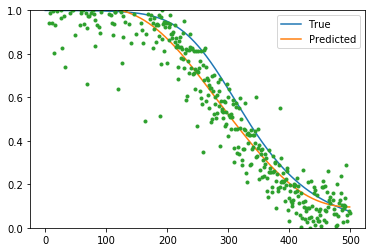

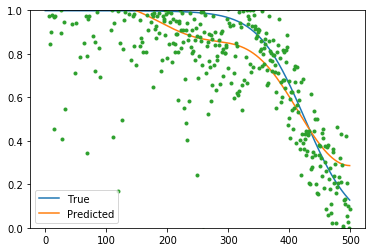

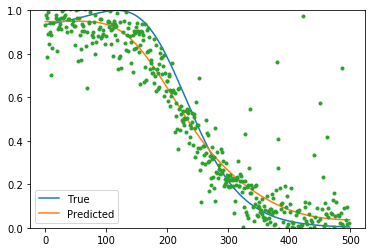

In [222]:
import scipy.ndimage.filters as sp
from scipy.special import softmax
y_test = model.predict(x_data)
for i in range(20):
    pdf=0
    pis=softmax(y_test[i,-N_MIXES:])
    for j in range(N_MIXES):
        mus=y_test[i,j*N_OUTPUT:N_OUTPUT*(j+1)]
        sigs=y_test[i,N_OUTPUT*(N_MIXES+j):N_OUTPUT*(N_MIXES+j+1)]
        pdf+=mus*pis[j]
    plt.plot(y_data[i,:],label='True')
    plt.plot(sp.gaussian_filter1d(pdf,50),label='Predicted')
    plt.plot(pdf,'.')
    plt.ylim((0,1))
    plt.legend()
    plt.show()

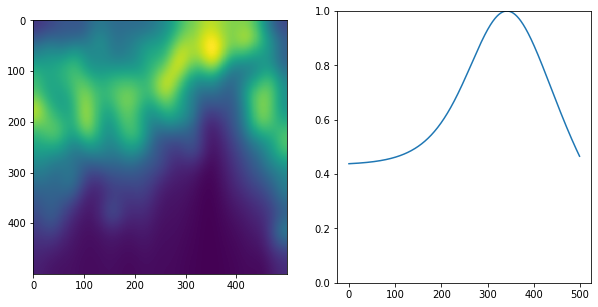

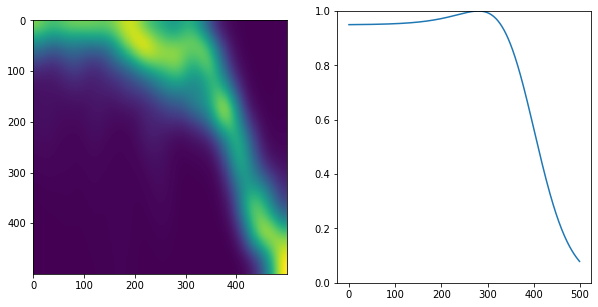

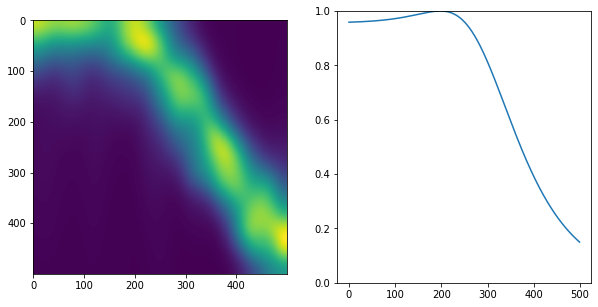

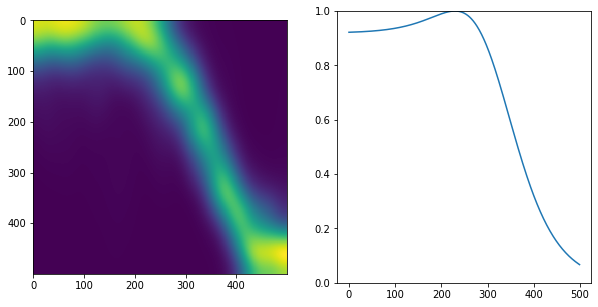

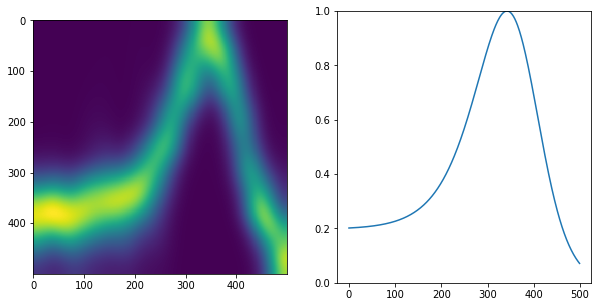

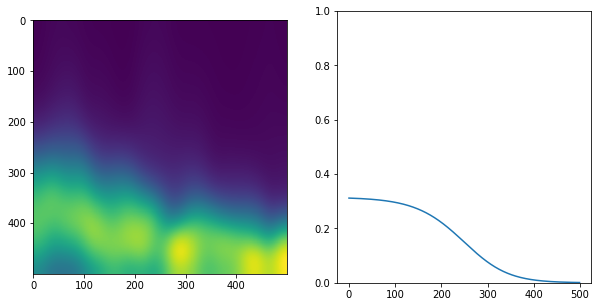

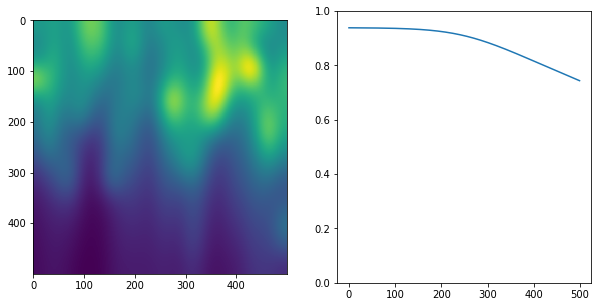

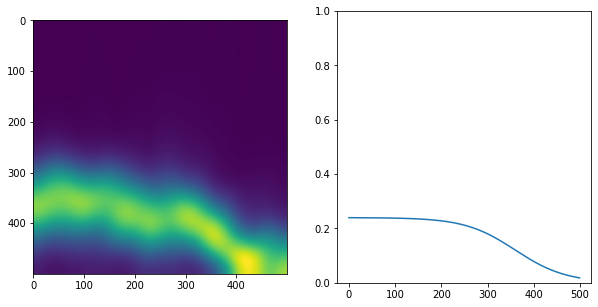

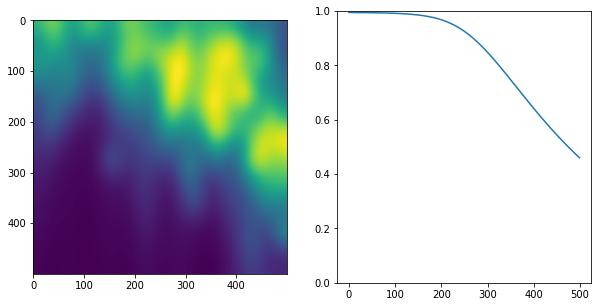

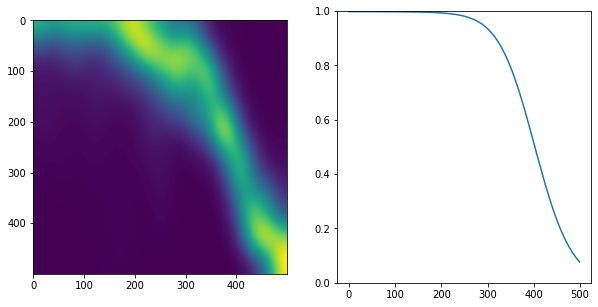

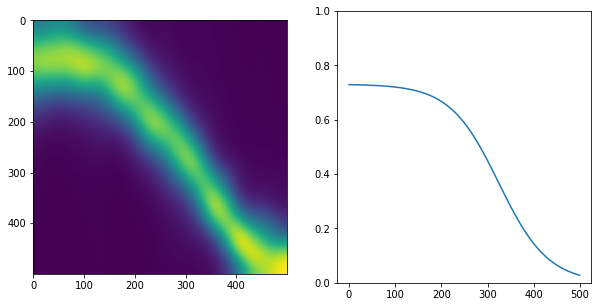

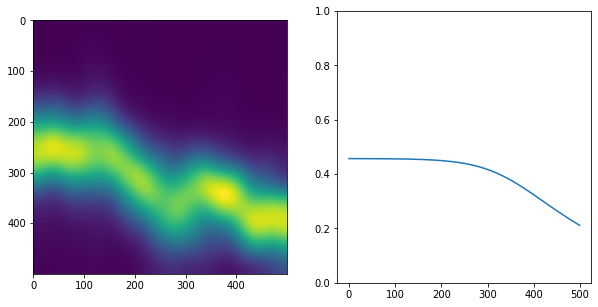

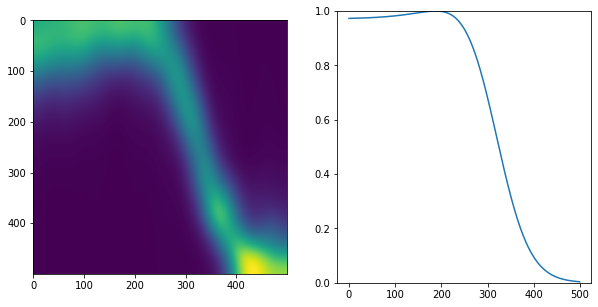

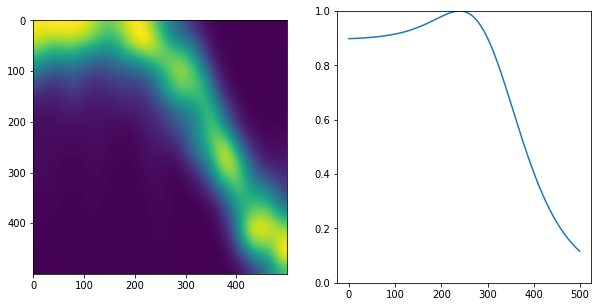

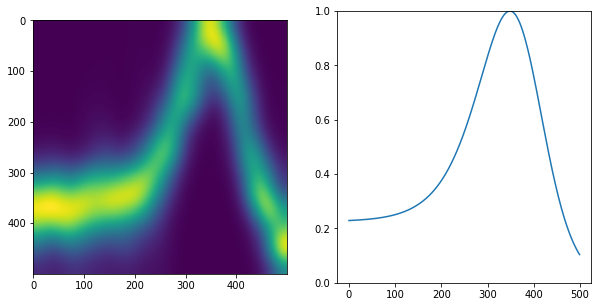

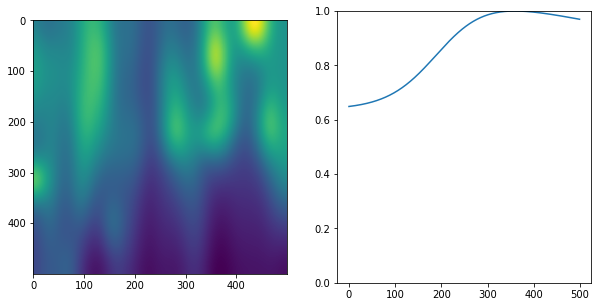

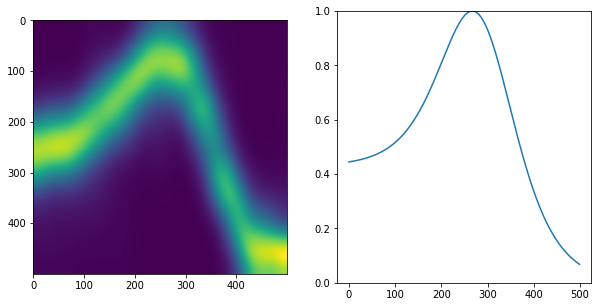

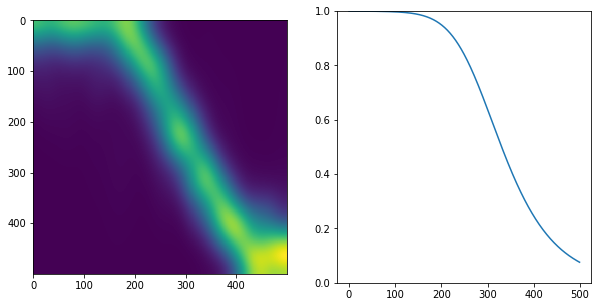

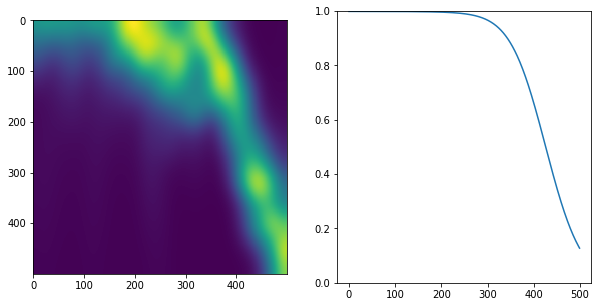

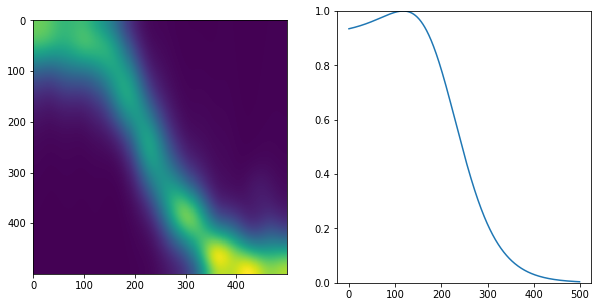

In [223]:
for i in range(20):
    #plt.plot(gaussian_filter1d(y_test[i,:500],40))
    x=range(N_OUTPUT)
    y=np.arange(0,1,0.002)
    c=np.zeros((len(y),N_OUTPUT))
    pis=softmax(y_test[i,-N_MIXES:])
    
    for j in range(N_MIXES):
        mus=y_test[i,j*N_OUTPUT:N_OUTPUT*(j+1)]
        sigs=y_test[i,N_OUTPUT*(N_MIXES+j):N_OUTPUT*(N_MIXES+j+1)]
        for k in range(N_OUTPUT):
            #c[:,k]+=pis[j]*np.exp(-(y-mus[k])**2/sigs[k]/2)/np.sqrt(2*np.pi*sigs[k])
            c[:,k]+=pis[j]*np.exp(-(y-mus[k])**2/sigs[k]**2/2)/np.sqrt(2*np.pi)/sigs[k]
    c=gaussian_filter(c,20)
    c=np.flipud(c)
    
    f=plt.figure(figsize=(10,5))
    ax1 = f.add_subplot(1,2,1, aspect=1)
    ax2 = f.add_subplot(1,2,2)
    
    ax1.imshow(c)
    ax2.plot(y_data[i,:])
    plt.ylim((0,1))